In [2]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
 
print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
dataset_dir = r'C:\Users\USER\Desktop\Deepfake Detection\FF++'

print("Dataset directory set to:", dataset_dir)

Dataset directory set to: C:\Users\USER\Desktop\Deepfake Detection\FF++


In [4]:
def load_video_frames(dataset_dir, frame_skip=30):
    images = []
    labels = []
    
    # Load face detector
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    for folder in os.listdir(dataset_dir):
        folder_path = os.path.join(dataset_dir, folder)
        if os.path.isdir(folder_path):
            print(f"Processing folder: {folder}")  # Debugging output
            
            for filename in os.listdir(folder_path):
                if filename.endswith('.mp4'):  # Process only video files
                    video_path = os.path.join(folder_path, filename)
                    cap = cv2.VideoCapture(video_path)
                    
                    if not cap.isOpened():
                        print(f"Error opening video: {video_path}")
                        continue
                    
                    frame_count = 0
                    while True:
                        ret, frame = cap.read()
                        if not ret:
                            break  # Stop when the video ends
                        
                        # Process every 'frame_skip' frame to reduce redundancy
                        if frame_count % frame_skip == 0:
                            # Convert to grayscale for face detection
                            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                            
                            # Detect faces
                            faces = face_cascade.detectMultiScale(gray, 1.1, 4)
                            
                            # If faces are found, process them
                            if len(faces) > 0:
                                # Process the largest face
                                x, y, w, h = sorted(faces, key=lambda x: x[2] * x[3], reverse=True)[0]
                                
                                # Add some margin
                                margin = int(w * 0.2)
                                x = max(0, x - margin)
                                y = max(0, y - margin)
                                w = min(frame.shape[1] - x, w + 2 * margin)
                                h = min(frame.shape[0] - y, h + 2 * margin)
                                
                                # Extract face ROI
                                face_roi = frame[y:y+h, x:x+w]
                                
                                # Resize face to standard size
                                face_roi = cv2.resize(face_roi, (224, 224))
                                
                                # Apply data augmentation for fake samples to increase dataset diversity
                                if 'fake' in folder:
                                    # Original face
                                    images.append(face_roi)
                                    labels.append(1)  # 1 for fake
                                    
                                    # Slightly rotated face (5 degrees)
                                    M = cv2.getRotationMatrix2D((face_roi.shape[1] / 2, face_roi.shape[0] / 2), 5, 1)
                                    rotated = cv2.warpAffine(face_roi, M, (face_roi.shape[1], face_roi.shape[0]))
                                    images.append(rotated)
                                    labels.append(1)
                                else:
                                    images.append(face_roi)
                                    labels.append(0)  # 0 for real
                        
                        frame_count += 1
                    
                    cap.release()
    
    print(f"Total frames extracted: {len(images)}")  # Debugging output
    return np.array(images), np.array(labels)

print("Function to extract video frames with face detection is ready!")

Function to extract video frames with face detection is ready!


In [5]:
images, labels = load_video_frames(dataset_dir)

# Check if images are loaded correctly
print(f"Images shape: {images.shape}")  # Should be (num_samples, 224, 224, 3)
print(f"Labels shape: {labels.shape}")  # Should be (num_samples,)

Processing folder: fake
Processing folder: real
Total frames extracted: 14976
Images shape: (14976, 224, 224, 3)
Labels shape: (14976,)


In [6]:
images = images / 255.0  # Scale pixel values to [0, 1]
print("Images normalized successfully!")

Images normalized successfully!


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

# Check dataset shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (11980, 224, 224, 3), y_train shape: (11980,)
X_test shape: (2996, 224, 224, 3), y_test shape: (2996,)


In [8]:
def build_improved_model():
    # Use a pre-trained model (EfficientNetB0) as the base
    base_model = applications.EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    # Freeze the base model
    base_model.trainable = False
    
    # Add custom layers on top
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    
    # Compile the model with a lower learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', 
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall'),
                 tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

# Create the model
model = build_improved_model()
print("Improved CNN model created successfully!")


Improved CNN model created successfully!


In [9]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,383,908 (16.72 MB)

 Trainable params: 331,265 (1.26 MB)

 Non-trainable params: 4,052,643 (15.46 MB)

In [10]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]
print("Training callbacks defined!")

Training callbacks defined!


In [11]:
history = model.fit(
    X_train, y_train,
    epochs=20,  
    batch_size=16,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)
print("Model training completed!")

Epoch 1/20
599/599 ━━━━━━━━━━━━━━━━━━━━ 266s 416ms/step - accuracy: 0.5150 - auc: 0.5074 - loss: 1.2998 - precision: 0.6264 - recall: 0.5589 - val_accuracy: 0.6427 - val_auc: 0.6987 - val_loss: 1.0591 - val_precision: 0.6427 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/20
599/599 ━━━━━━━━━━━━━━━━━━━━ 229s 382ms/step - accuracy: 0.5443 - auc: 0.4982 - loss: 1.2116 - precision: 0.6236 - recall: 0.6865 - val_accuracy: 0.6427 - val_auc: 0.6963 - val_loss: 1.0376 - val_precision: 0.6427 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/20
599/599 ━━━━━━━━━━━━━━━━━━━━ 268s 392ms/step - accuracy: 0.5559 - auc: 0.4961 - loss: 1.1740 - precision: 0.6217 - recall: 0.7317 - val_accuracy: 0.6427 - val_auc: 0.6985 - val_loss: 1.0203 - val_precision: 0.6427 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/20
599/599 ━━━━━━━━━━━━━━━━━━━━ 238s 397ms/step - accuracy: 0.5742 - auc: 0.5182 - loss: 1.1255 - precision: 0.6326 - recall: 0.7662 - val_accuracy: 0.6427 - val_auc: 0.7

In [ ]:
results = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")
print(f"Test Precision: {results[2]:.4f}")
print(f"Test Recall: {results[3]:.4f}")
print(f"Test AUC: {results[4]:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 49s 522ms/step - accuracy: 0.6359 - auc: 0.7349 - loss: 0.7729 - precision: 0.6359 - recall: 1.0000
Test Loss: 0.7763
Test Accuracy: 0.6305
Test Precision: 0.6305
Test Recall: 1.0000
Test AUC: 0.7279


In [13]:
model.save('improved_deepfake_model.keras')
print("Model saved as 'improved_deepfake_model.keras'")

Model saved as 'improved_deepfake_model.keras'


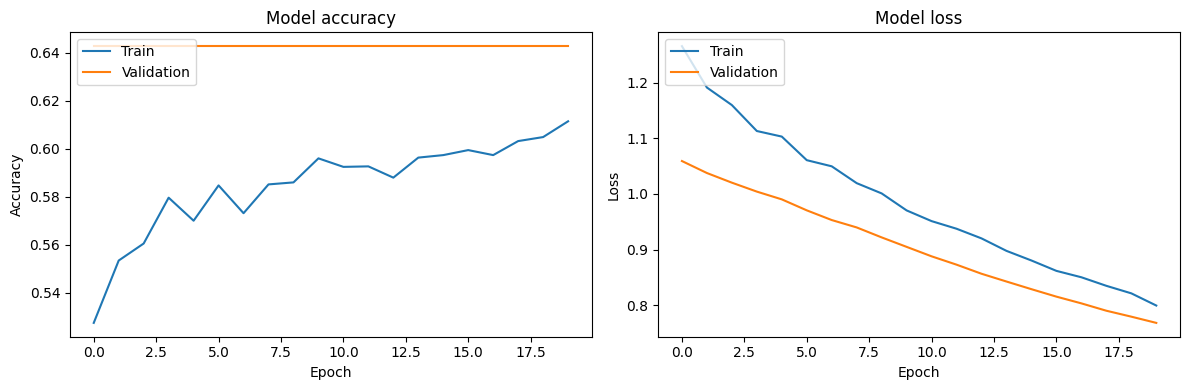

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [15]:
model.save('saveModel.keras')

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np

# Load model (provide your exact filename here)
model = tf.keras.models.load_model("saveModel.keras")

# Optional: define class names if available
# class_names = ['real', 'fake']  # Modify as per your dataset

def predict_image_class(img_path):
    # Load image and resize to model input size (typically 224x224 for EfficientNetB0)
    img = image.load_img(img_path, target_size=(224, 224))
    
    # Convert to array
    img_array = image.img_to_array(img)
    
    # Expand dimensions to match model input shape (1, 224, 224, 3)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Preprocess input for EfficientNetB0
    img_array = preprocess_input(img_array)

    # Make prediction
    predictions = model.predict(img_array)
    
    # Assuming binary classification (real/fake)
    predicted_class = int(predictions[0][0] > 0.2)  # 1 if >0.5, else 0

    # If you have class names, return name instead
    # return class_names[predicted_class]
    
    return predicted_class


In [6]:
result = predict_image_class("TC_real.jpg")
if result==0:
    print("The image provided is a deepfake")
else:
    print("The image provided is real")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
The image provided is real
